In [0]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

answers = dict(np.load('gan-checks-tf.npz'))

0it [00:00, ?it/s]

9920512it [00:01, 9353827.97it/s]                            


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 143097.46it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw


1654784it [00:00, 2257541.59it/s]                            
8192it [00:00, 54555.11it/s]            


Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw
Extracting ./cs231n/datasets/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./cs231n/datasets/MNIST_data/MNIST/raw
Processing...
Done!


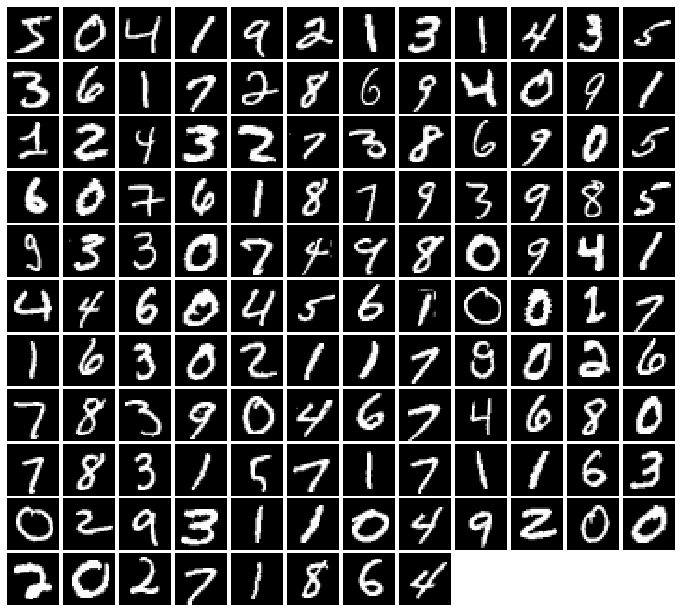

In [48]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [0]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    rand_noise = (torch.rand((batch_size, dim)) - 0.5) * 2
    return rand_noise

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [50]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [0]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [0]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 1)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )
    return model

In [55]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')     

test_discriminator()

Correct number of parameters in discriminator.


In [0]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            nn.Linear(noise_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )
    return model

In [58]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


In [0]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [0]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    
    loss_real = bce_loss(logits_real, torch.ones(logits_real.size(0)).type(dtype))
    loss_fake = bce_loss(logits_fake, torch.zeros(logits_real.size(0)).type(dtype))
    
    return loss_real + loss_fake
    

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    
    return bce_loss(logits_fake, torch.ones_like(logits_fake))

In [65]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 2.83811e-08


In [70]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 4.4518e-09


In [0]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

In [0]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.368, G:0.7303


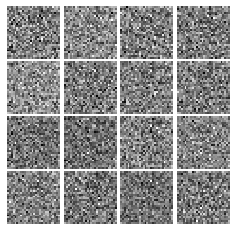


Iter: 250, D: 1.236, G:0.7193


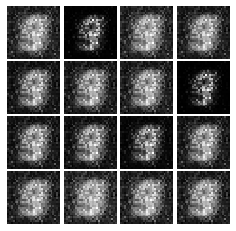


Iter: 500, D: 0.9808, G:1.537


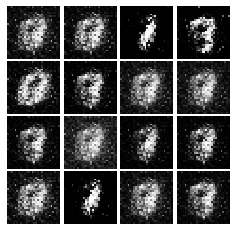


Iter: 750, D: 1.26, G:0.7105


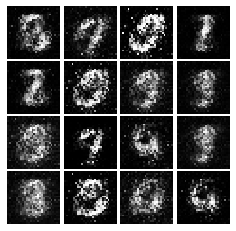


Iter: 1000, D: 0.9999, G:0.6947


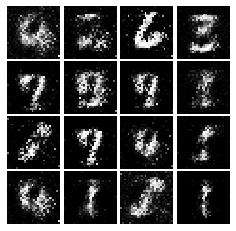


Iter: 1250, D: 1.142, G:1.09


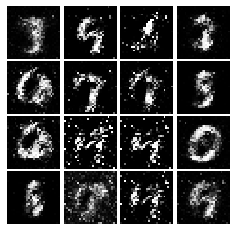


Iter: 1500, D: 1.298, G:0.8795


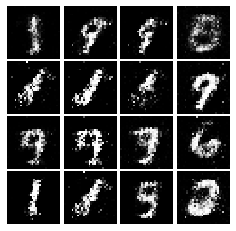


Iter: 1750, D: 1.31, G:0.8907


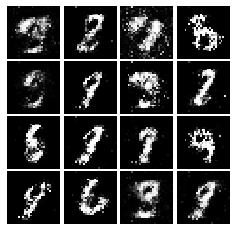


Iter: 2000, D: 1.304, G:0.9071


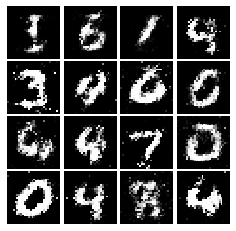


Iter: 2250, D: 1.419, G:0.8978


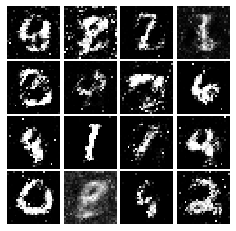


Iter: 2500, D: 1.21, G:1.01


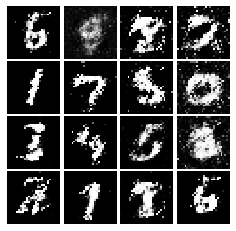


Iter: 2750, D: 1.27, G:0.8865


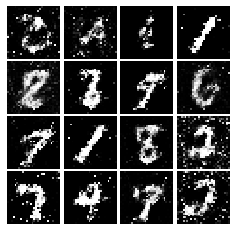


Iter: 3000, D: 1.282, G:0.9951


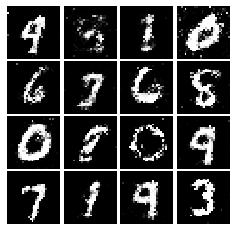


Iter: 3250, D: 1.303, G:0.9376


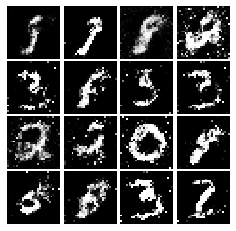


Iter: 3500, D: 1.344, G:0.8159


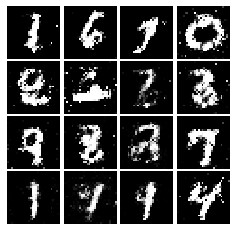


Iter: 3750, D: 1.379, G:0.7723


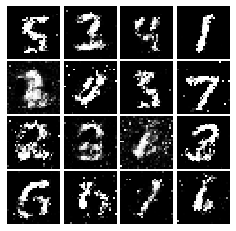

In [73]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

In [0]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5 * torch.mean((scores_real - 1) ** 2) + 0.5 * torch.mean(scores_fake ** 2)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    loss = 0.5 * torch.mean((scores_fake - 1) ** 2)
    return loss

In [75]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Iter: 0, D: 0.5207, G:0.4916


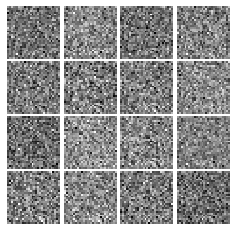


Iter: 250, D: 0.162, G:0.2711


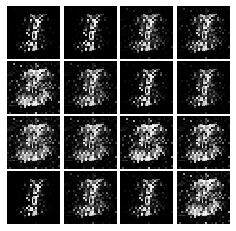


Iter: 500, D: 0.1649, G:0.6596


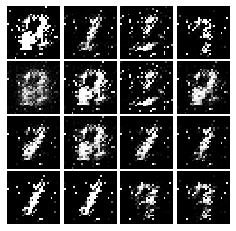


Iter: 750, D: 0.1603, G:0.3595


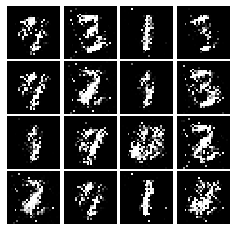


Iter: 1000, D: 0.1006, G:0.4231


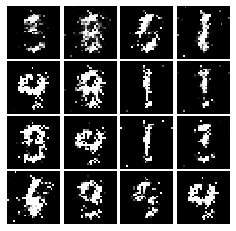


Iter: 1250, D: 0.1536, G:0.2276


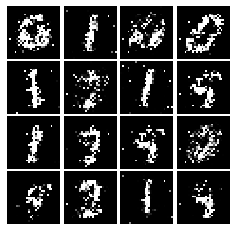


Iter: 1500, D: 0.2063, G:0.1632


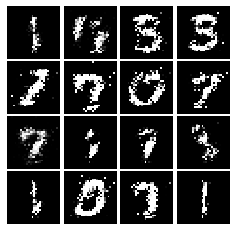


Iter: 1750, D: 0.1794, G:0.1843


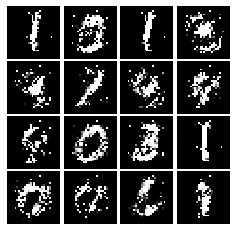


Iter: 2000, D: 0.2437, G:0.1812


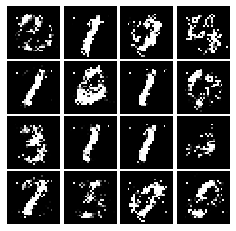


Iter: 2250, D: 0.228, G:0.1869


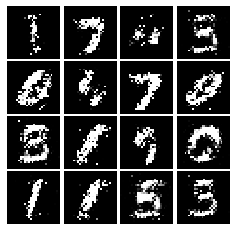


Iter: 2500, D: 0.1896, G:0.1815


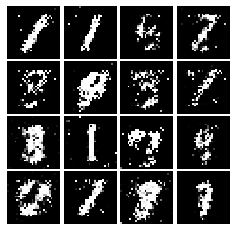


Iter: 2750, D: 0.2222, G:0.1482


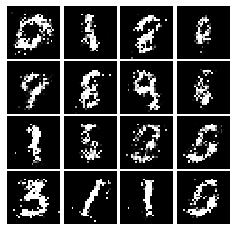


Iter: 3000, D: 0.226, G:0.1692


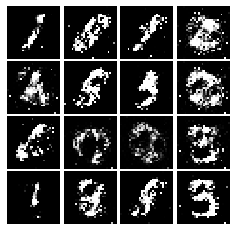


Iter: 3250, D: 0.2372, G:0.1989


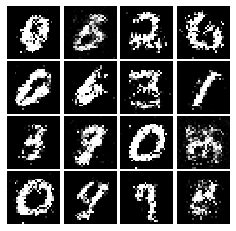


Iter: 3500, D: 0.2311, G:0.1565


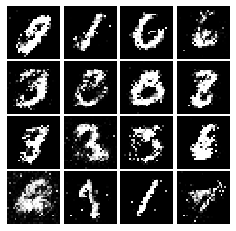


Iter: 3750, D: 0.2442, G:0.1397


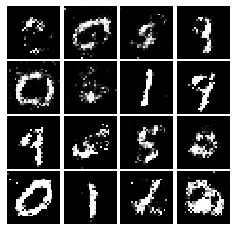

In [76]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

In [77]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(0.01),
        nn.Linear(4*4*64, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


In [78]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


In [79]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024), # Note: nn.BatchNorm1d
        nn.Linear(1024, 7*7*128),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128), # Note: nn.BatchNorm1d
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

In [80]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


Iter: 0, D: 1.456, G:1.375


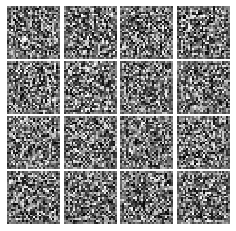


Iter: 250, D: 1.4, G:1.269


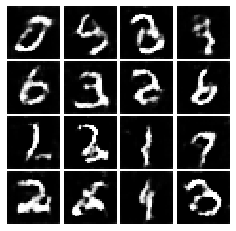


Iter: 500, D: 1.16, G:0.9676


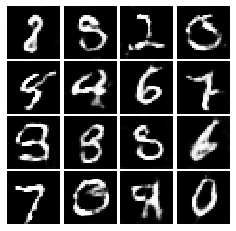


Iter: 750, D: 1.204, G:1.157


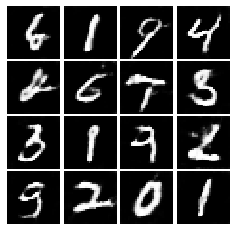


Iter: 1000, D: 1.276, G:0.9998


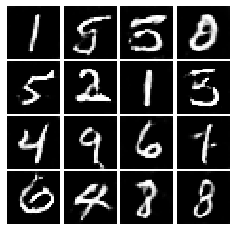


Iter: 1250, D: 1.286, G:0.9979


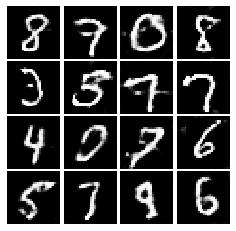


Iter: 1500, D: 1.141, G:0.9308


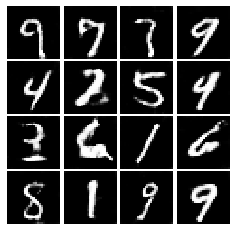


Iter: 1750, D: 1.143, G:0.8095


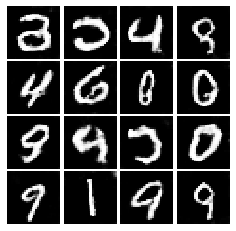

In [81]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)